In [3]:
import os
import sys
from pathlib import Path
import json
import re
from collections import Counter

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

import pypdfium2 as pdfium
import pypdfium2.raw as pdfium_c

In [5]:
from cdlib import evaluation, NodeClustering

In [6]:
from tqdm.notebook import tqdm

In [7]:
docs_meta_csv_path = Path("data_pdfs/docs_metadata.csv")
docs_meta_df = pd.read_csv(docs_meta_csv_path)
docs_meta_df

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,topics,filename,filepath
0,q-alg/9705012,Jean Avan,"J. Avan, L. Frappat, M. Rossi, P. Sorba",Poisson structures on the center of the ellipt...,LaTeX 2.09 Document (should be run twice),Phys.Lett. A235 (1997) 323,10.1016/S0375-9601(97)00637-3,ENSLAPP-AL-644/97; CRM-2474; PAR-LPTHE 97/17,q-alg hep-th math.QA,NaN,"It is shown that the elliptic algebra A_{p,q...","[{'version': 'v1', 'created': 'Fri, 16 May 199...",2016-09-08,"[['Avan', 'J.', ''], ['Frappat', 'L.', ''], ['...","[""Physics"", ""Mathematics""]",q-alg 9705012.pdf,data_pdfs/pdfs/q-alg 9705012.pdf
1,1510.08818,Haydar Abdel Hamid,Haydar Abdel Hamid and Waad Al Sayed,Integrable solutions of a generalized mixed-ty...,25 pages,NaN,NaN,NaN,math.CA,http://arxiv.org/licenses/nonexclusive-distrib...,"In this work, we prove the existence of inte...","[{'version': 'v1', 'created': 'Mon, 26 Oct 201...",2015-10-30,"[['Hamid', 'Haydar Abdel', ''], ['Sayed', 'Waa...","[""Mathematics""]",1510.08818.pdf,data_pdfs/pdfs/1510.08818.pdf
2,hep-th/0511166,Eve Mariel Santangelo,C.G. Beneventano and E.M. Santangelo,Finite-temperature relativistic Landau problem...,"Final version, to appear in Journal of Physics...",J.Phys. A39 (2006) 7457-7470,10.1088/0305-4470/39/23/019,NaN,hep-th cond-mat.mes-hall math-ph math.MP,NaN,This paper presents a study of the free ener...,"[{'version': 'v1', 'created': 'Wed, 16 Nov 200...",2009-11-11,"[['Beneventano', 'C. G.', ''], ['Santangelo', ...","[""Physics"", ""Physics"", ""Mathematics"", ""Mathema...",hep-th 0511166.pdf,data_pdfs/pdfs/hep-th 0511166.pdf
3,1212.1320,Antoine Julien,Antoine Julien,Complexity as a homeomorphism invariant for ti...,Added a the result on the repetitivity functio...,NaN,NaN,NaN,math.DS,http://arxiv.org/licenses/nonexclusive-distrib...,It is proved that whenever two aperiodic rep...,"[{'version': 'v1', 'created': 'Thu, 6 Dec 2012...",2014-01-09,"[['Julien', 'Antoine', '']]","[""Mathematics""]",1212.1320.pdf,data_pdfs/pdfs/1212.1320.pdf
4,2009.03043,Miho Murata,Takayuki Kobayashi and Miho Murata,The global well-posedness of the compressible ...,13 pages. arXiv admin note: substantial text o...,NaN,NaN,NaN,math.AP,http://arxiv.org/licenses/nonexclusive-distrib...,"In this paper, we consider the compressible ...","[{'version': 'v1', 'created': 'Fri, 4 Sep 2020...",2020-09-08,"[['Kobayashi', 'Takayuki', ''], ['Murata', 'Mi...","[""Mathematics""]",2009.03043.pdf,data_pdfs/pdfs/2009.03043.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,1905.11229,Haoyan Liu,"Haoyan Liu, Yanming Liu, Ming Yang and Xiaopin...",A Novel Demodulation and Estimation Algorithm ...,NaN,NaN,NaN,NaN,eess.SP cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,"For reentry or near space communication, owi...","[{'version': 'v1', 'created': 'Mon, 27 May 201...",2019-05-31,"[['Liu', 'Haoyan', ''], ['Liu', 'Yanming', '']...","[""Electrical Engineering and Systems Science"",...",1905.11229.pdf,data_pdfs/pdfs/1905.11229.pdf
1315,2412.18588,Shaohong Zhong,"OpenMind, Shaohong Zhong, Adam Zhou, Boyuan Ch...",A Paragraph is All It Takes: Rich Robot Behavi...,"10 pages, 1 figure",NaN,NaN,NaN,cs.RO cs.AI cs.SY eess.SY,http://creativecommons.org/licenses/by-nc-nd/4.0/,Large Language Models (LLMs) are compact rep...,"[{'version': 'v1', 'created': 'Tue, 24 Dec 202...",2024-12-25,"[['OpenMind', '', ''], ['Zhong', 'Shaohong', '...","[""Computer Science"", ""Computer Science"", ""Comp...",2412.18588.pdf,data_pdfs/pdfs/2412.18588.pdf
1316,2006.16661,Siyuan Liu,"Siyuan Liu, Abdalla Swikir and Majid Zamani",Verification of Initial-State Opacity for Swit...,"19 pages, 7 figures","Nonlinear Analysis: Hybrid Systems, vol. 42, N...",10.1016/j.nahs.2021.101084,NaN,eess.SY cs.SY,http://arxiv.org/licenses/nonexclusive-distrib...,The security in information-flow has become ...,"[{'version': 'v1', 'created': 'Tue, 30 Jun 202...",2021-

### Topic distribution

([<matplotlib.patches.Wedge at 0x155513919d50>,
 [Text(0.9293768831218531, 0.5884374300796218, 'Physics'),
  Text(-0.268333941337537, 1.0667693733540833, 'Mathematics'),
  Text(-1.0339493017820607, -0.3754315401566435, 'Computer Science'),
  Text(0.19581664631063825, -1.0824305248040886, 'Statistics'),
  Text(0.9195294831914522, -0.6037098057358858, 'Electrical Engineering and Systems Science'),
  Text(1.0924773219996755, -0.12842624699187297, 'Quantitative Biology'),
  Text(1.09939964119561, -0.03633770684790513, 'Quantitative Finance'),
  Text(1.0999489244822693, -0.010600166522225406, 'Economics')],
 [Text(0.5069328453391925, 0.32096587095252094, '18.0%'),
  Text(-0.1463639680022929, 0.5818742036476817, '21.9%'),
  Text(-0.5639723464265785, -0.20478084008544187, '31.3%'),
  Text(0.10680907980580266, -0.5904166498931391, '13.3%'),
  Text(0.5015615362862466, -0.3292962576741195, '12.5%'),
  Text(0.595896721090732, -0.07005068017738525, '2.2%'),
  Text(0.5996725315612417, -0.0198205673

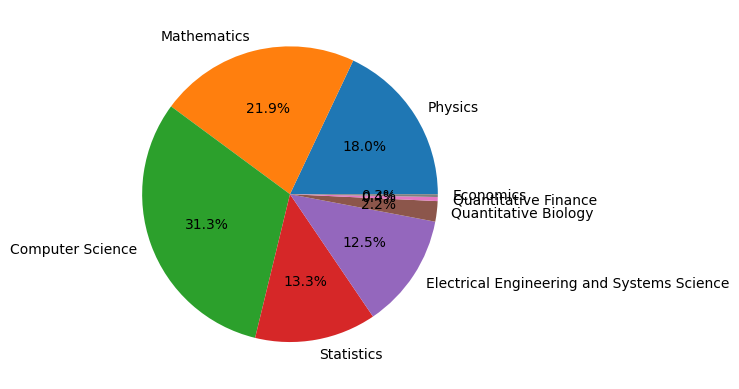

In [8]:
true_topics_all = []
for i in range(len(docs_meta_df)):
    true_topics_all.extend(list(set(json.loads(docs_meta_df['topics'].iloc[i]))))

topics_counter = Counter(true_topics_all)
plt.pie(topics_counter.values(),
        labels=topics_counter.keys(), autopct='%1.1f%%')

# Result Analyses

In [15]:
with open("data/misc/arxiv_topics.yaml") as f:
    topics_conf = yaml.safe_load(f)
topic_names = []
for d in topics_conf['topics']:
    topic_names.append(d['name'])
print(f"{topic_names=}")

topic_names=['Computer Science', 'Economics', 'Electrical Engineering and Systems Science', 'Mathematics', 'Physics', 'Quantitative Biology', 'Quantitative Finance', 'Statistics']


In [7]:
sample_assigs = []
with open("data/output/sample/assignment.jsonl", encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            sample_assigs.append(json.loads(line))
sample_assigs[0]

{'id': '111-HR-3692',
 'text': 'National Forest Roadless Area Conservation Act - Identifies roadless areas within the National Forest System set forth in specified maps as National Forest Inventoried Roadless Areas, and directs the Secretary of Agriculture to manage such Areas to maintain their roadless character. Authorizes the Forest Service to modify such maps for the sole purpose of improving their accuracy or inclusiveness. Requires any substantial modification of those maps to be made through the national forest management planning process and documented in an environmental impact statement.',
 'label': 'Public Lands',
 'prompted_docs': 'National Forest Roadless Area Conservation Act - Identifies roadless areas within the National Forest System set forth in specified maps as National Forest Inventoried Roadless Areas, and directs the Secretary of Agriculture to manage such Areas to maintain their roadless character. Authorizes the Forest Service to modify such maps for the sole p

In [10]:
assig_base_dir = Path("output/topic_assignments/20250417T203941/")
assig_outputs_all = {
    'bertopic_first_page': {
        'path': assig_base_dir / "bertopic_first_page/all_results.json"
    },
    'bertopic_random_page': {
        'path': assig_base_dir / "bertopic_random_page/all_results.json"
    },
    'bertopic_2_random_pages': {
        'path': assig_base_dir / "bertopic_2_random_pages/all_results.json"
    },
    'vlm_first_page': {
        'path': assig_base_dir / "vlm_first_page/all_results.json",
    },
    'vlm_random_page': {
        'path': assig_base_dir / "vlm_random_page/all_results.json",
    },
    'vlm_2_random_pages': {
        'path': assig_base_dir / "vlm_2_random_pages/all_results.json",
    },
    
    'llm_first_page': {
        'path': assig_base_dir / "llm_first_page/all_results.json",
    },
    'llm_random_page': {
        'path': assig_base_dir / "llm_random_page/all_results.json",
    },
    'llm_2_random_pages': {
        'path': assig_base_dir / "llm_2_random_pages/all_results.json",
    },
}
for k, assig_d in assig_outputs_all.items():
    assert os.path.isfile(assig_d['path']), "Invalid path: {}".format(assig_d['path'])

In [11]:
def identify_matched_topics_from_response(response: str, topic_names: list):
    keywords = ["Final Answer", "Final answer", "final answer", "Conclusion", "In conclusion"]
    for kw in keywords:
        if kw in response:
            response = response[response.index(kw)+len(kw):]
            break
    output_pattern = r"\[(?:\d+)\] ([^:]+): (?:.+)"
    output_topics = re.findall(output_pattern, response)
    output_topics = [t for t in output_topics if t in topic_names]
    if len(output_topics) == 0:
        found_topics = []
        for topic_name in topic_names:
            if topic_name in response:
                found_topics.append((response.index(topic_name), topic_name))
        for _, topic_name in sorted(found_topics):
            output_topics.append(topic_name)
    return output_topics

In [12]:
from topicgpt_python.utils import calculate_metrics

INFO 04-21 15:43:50 [__init__.py:243] No platform detected, vLLM is running on UnspecifiedPlatform


In [16]:
results_allmodels = []

pick1topic_sorted_alphabetically = True
for imodel, (model_name, assig_output_d) in enumerate(assig_outputs_all.items()):
    print("Model {}/{}: {}".format(imodel+1, len(assig_outputs_all), model_name))
    with open(assig_output_d['path'], encoding='utf-8') as f:
        assig_datas = json.load(f)
    curmodel_assig_datas_fordf = []
    true_topics_unique = set()
    pred_topics_unique = set()
    gt_pred_topic_names_match = "bertopic" not in model_name.lower()
    for idoc, assig_d in enumerate(tqdm(assig_datas)):
        true_topics = json.loads(assig_d['topics'])
        llm_response = assig_d.get('response', None)
        if llm_response is not None:
            pred_topics = identify_matched_topics_from_response(assig_d['response'], topic_names=topic_names)
        else:
            pred_topics = assig_d['matched_topics']
        if pick1topic_sorted_alphabetically:
            true_topics = sorted(set(true_topics))
            pred_topics = sorted(set(pred_topics))
        curmodel_assig_datas_fordf.append({
            'gt': true_topics[0],
            'pred': pred_topics[0] if len(pred_topics) > 0 else "XXXX",
            'gt_all': true_topics,
            'pred_all': pred_topics,
        })
        true_topics_unique.update(true_topics)
        pred_topics_unique.update(pred_topics)

    both_included_topics_unique = true_topics_unique.intersection(pred_topics_unique)
    for i, d in enumerate(curmodel_assig_datas_fordf):
        true_topics_ix = [t for t in d['gt_all'] if t in both_included_topics_unique]
        pred_topics_ix = [t for t in d['pred_all'] if t in both_included_topics_unique]
        d['gt_ix'] = true_topics_ix or ['DUMMY']
        if i == 0:
            d['gt_ix'].append('DUMMY') # Need at least 1 DUMMY in gt_ix
        d['pred_ix'] = pred_topics_ix or ['DUMMY']

    cur_model_assigdf = pd.DataFrame(curmodel_assig_datas_fordf)
    harmonic_purity, ari, mis = calculate_metrics('gt', 'pred', cur_model_assigdf)

    results_d = {
        'name': model_name,
        'harmonic_purity': harmonic_purity,
        'ari': ari,
        'mis': mis,
    }

    if False:# gt_pred_topic_names_match:
        print("Creating node clusterings")
        gt_nc = NodeClustering(communities=cur_model_assigdf['gt_all'].tolist(), graph=None, method_name="ground_truth")
        pred_nc = NodeClustering(communities=cur_model_assigdf['pred_all'].tolist(), graph=None, method_name="prediction")
        gt_ix_nc = NodeClustering(communities=cur_model_assigdf['gt_ix'].tolist(), graph=None, method_name="ground_truth")
        pred_ix_nc = NodeClustering(communities=cur_model_assigdf['pred_ix'].tolist(), graph=None, method_name="prediction")

        print("Computing ONMI LFK (can take ~20 minutes)")
        onmi_lfk = evaluation.overlapping_normalized_mutual_information_LFK(gt_nc, pred_nc)
        print("Computing ONMI MGH")
        onmi_mgh = evaluation.overlapping_normalized_mutual_information_MGH(gt_nc, pred_nc)
        print("Computing Omega")
        omega = evaluation.omega(gt_ix_nc, pred_ix_nc)
        #print("Computing ARI")
        #ari = evaluation.adjusted_rand_index(gt_ix_nc, pred_ix_nc)
        print("Computing F1")
        f1 = evaluation.f1(gt_ix_nc, pred_ix_nc)
        print("Computing Overlap Quality")
        overlap_q = evaluation.overlap_quality(gt_ix_nc, pred_ix_nc)
        print("Computing Variation of Information")
        voi = evaluation.variation_of_information(gt_ix_nc, pred_ix_nc)
        #print("Computing ECS")
        #ecs = evaluation.ecs(gt_ix_nc, pred_ix_nc)
        print("Computing Classification Error")
        classification_err = evaluation.classification_error(gt_ix_nc, pred_ix_nc)
        results_d = {
            **results_d,
            'onmi_lfk': onmi_lfk.score,
            'onmi_mgh': onmi_mgh.score,
            'omega': omega.score,
            #'ari': ari.score,
            'f1': f1.score,
            'overlap_quality': overlap_q.score,
            'variation_of_information': voi.score,
            #'ecs': ecs.score,
            'classification_error': classification_err.score,
        }

    results_allmodels.append(results_d)
results_allmodels_df = pd.DataFrame(results_allmodels).set_index('name')
results_allmodels_df

Model 1/9: bertopic_first_page


  0%|          | 0/1312 [00:00<?, ?it/s]

Model 2/9: bertopic_random_page


/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


  0%|          | 0/1312 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 3/9: bertopic_2_random_pages


  0%|          | 0/1312 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 4/9: vlm_first_page


  0%|          | 0/1312 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 5/9: vlm_random_page


  0%|          | 0/1312 [00:00<?, ?it/s]

Model 6/9: vlm_2_random_pages


/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


  0%|          | 0/1312 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 7/9: llm_first_page


  0%|          | 0/1312 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 8/9: llm_random_page


  0%|          | 0/1312 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 9/9: llm_2_random_pages


  0%|          | 0/1312 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


,harmonic_purity,ari,mis
name,,,
bertopic_first_page,0.375433,0.051650,0.259208
bertopic_random_page,0.407996,0.043234,0.214806
bertopic_2_random_pages,0.396644,0.051749,0.220844
vlm_first_page,0.506449,0.124440,0.081735
vlm_random_page,0.497398,0.068405,0.035824
vlm_2_random_pages,0.528951,0.142059,0.102739
llm_first_page,0.715769,0.433894,0.317237
llm_random_page,0.624485,0.288821,0.207378
llm_2_random_pages,0.506471,0.137844,0.129607


In [60]:
pred_topics_unique

{'Computer Science',
 'Economics',
 'Electrical Engineering and Systems Science',
 'Mathematics',
 'Physics',
 'Quantitative Biology',
 'Quantitative Finance',
 'Statistics'}

In [67]:
# Seems to perform poorly if cluster names differ
# Should not matter in our case
gt_clusters = [[4, 1], [2, 3], [9, 10]]            # ground truth clustering
pred_clusters = 1 * np.array([[4, 2], [1, 3], [9, 10]])          # Predicted clustering

gt_clusters = [["40", "11"], ["22", "30"], ["99", "100"]]            # ground truth clustering
pred_clusters = [["40", "22"], ["11", "22", "30", "100"], ["99"]]          # Predicted clustering

# Create NodeClustering objects
gt_nc = NodeClustering(communities=gt_clusters, graph=None, method_name="ground_truth")
pred_nc = NodeClustering(communities=pred_clusters, graph=None, method_name="prediction")

# Compute Omega Index
onmi_lfk = evaluation.overlapping_normalized_mutual_information_LFK(gt_nc, pred_nc)
onmi_mgh = evaluation.overlapping_normalized_mutual_information_MGH(gt_nc, pred_nc)

omega = evaluation.omega(gt_nc, pred_nc)
#ari = evaluation.adjusted_rand_index(gt_nc, pred_nc)
#f1 = evaluation.f1(gt_nc, pred_nc)
#overlap_q = evaluation.overlap_quality(gt_nc, pred_nc)
#voi = evaluation.variation_of_information(gt_nc, pred_nc)
#ecs = evaluation.ecs(gt_nc, pred_nc)
#classification_err = evaluation.classification_error(gt_nc, pred_nc)
print("(Test) Overlapping NMI (LFK):", onmi_lfk.score)
print("(Test) Overlapping NMI (MGH):", onmi_mgh.score)
print("(Test) Omega Index:", omega.score)
#print("(Test) ARI:", ari.score)
#print("(Test) F1:", f1.score)
#print("(Test) Overlap Quality:", overlap_q.score)
#print("(Test) Variation of information:", voi.score)
#print("(Test) ECS:", ecs.score)
#print("(Test) Classification error:", classification_err.score)

(Test) Overlapping NMI (LFK): 0.2460280855063084
(Test) Overlapping NMI (MGH): 0.22230623681376885
(Test) Omega Index: -0.11111111111111113


In [ ]:
dir(evaluation)

['ComparisonRanking',
 'FitnessRanking',
 'FitnessResult',
 'MatchingResult',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'adjusted_mutual_information',
 'adjusted_rand_index',
 'average_internal_degree',
 'avg_distance',
 'avg_embeddedness',
 'avg_odf',
 'avg_transitivity',
 'classification_error',
 'comparison',
 'comparisonranking',
 'conductance',
 'cut_ratio',
 'czekanowski_index',
 'dice_index',
 'ecs',
 'edges_inside',
 'elem',
 'erdos_renyi_modularity',
 'expansion',
 'f1',
 'fitness',
 'fitnessranking',
 'flake_odf',
 'fowlkes_mallows_index',
 'fraction_over_median_degree',
 'geometric_accuracy',
 'hub_dominance',
 'internal',
 'internal_edge_density',
 'jaccard_index',
 'link_modularity',
 'max_odf',
 'mi',
 'modularity_density',
 'modularity_overlap',
 'newman_girvan_modularity',
 'nf1',
 'normalized_cut',
 'normalized_mutual_information',
 'omega',
 'overlap_quality',
 'overlapping_normalize

### Count figures
- Ref: [pypdfium2/src/pypdfium2/_cli/extract_images.py](https://github.com/pypdfium2-team/pypdfium2/blob/main/src/pypdfium2/_cli/extract_images.py)

In [18]:
n_images_docs = {}
for idoc, assig_d in enumerate(pbar := tqdm(assig_datas)):
    pdf_obj = pdfium.PdfDocument(assig_d['filepath'])
    pages = assig_d.get('pages', [0])
    n_images = 0
    for page in pages:
        images = pdf_obj[page].get_objects(
                filter = (pdfium_c.FPDF_PAGEOBJ_IMAGE, ),
                max_depth = 15,
            )
        n_images += len(list(images))
    if n_images > 10:
        print(f"PDF: {assig_d['filename']} pages: {assig_d['pages']} # images: {n_images}")
    n_images_docs[idoc] = n_images
    n_images_avg = sum(n_images_docs.values()) / len(n_images_docs)
    pbar.set_description(f"#images: {n_images}; avg: {n_images_avg:.01f}")

n_images_avg = sum(n_images_docs.values()) / len(n_images_docs)
print(f"Avg # images on page {page}: {n_images_avg:.01f}")
# TODO for documents with many images (e.g., >15), manually check page

  0%|          | 0/1312 [00:00<?, ?it/s]

PDF: hep-th 0511166.pdf pages: [8, 3] # images: 82
PDF: 2009.03043.pdf pages: [2, 4] # images: 26
PDF: 1711.04932.pdf pages: [6, 18] # images: 15
PDF: 1706.05147.pdf pages: [4, 9] # images: 12
PDF: 2404.13739.pdf pages: [0, 3] # images: 17
PDF: 1510.08934.pdf pages: [28, 26] # images: 30
PDF: math 0507108.pdf pages: [5, 3] # images: 63
PDF: 1405.2593.pdf pages: [14, 3] # images: 24
PDF: 2102.10568.pdf pages: [2, 12] # images: 35
PDF: 2107.10671.pdf pages: [6, 4] # images: 36
PDF: 1306.4549.pdf pages: [8, 12] # images: 37
PDF: 1910.02741.pdf pages: [0, 4] # images: 18
PDF: 1506.05205.pdf pages: [29, 12] # images: 94
PDF: 2205.02176.pdf pages: [24, 10] # images: 26
PDF: 0912.2135.pdf pages: [3, 7] # images: 145
PDF: 1910.08723.pdf pages: [3, 1] # images: 47
PDF: 1203.4983.pdf pages: [0, 6] # images: 13
PDF: 2502.12332.pdf pages: [5, 12] # images: 31
PDF: 1609.08230.pdf pages: [5, 0] # images: 13
PDF: math 9508202.pdf pages: [3, 7] # images: 22
PDF: 1604.00797.pdf pages: [3, 21] # images: